In [32]:
%matplotlib notebook
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%load_ext autoreload
%autoreload 2

import reconstruct_3d as r3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
name = "library"
plot = True

<IPython.core.display.Javascript object>


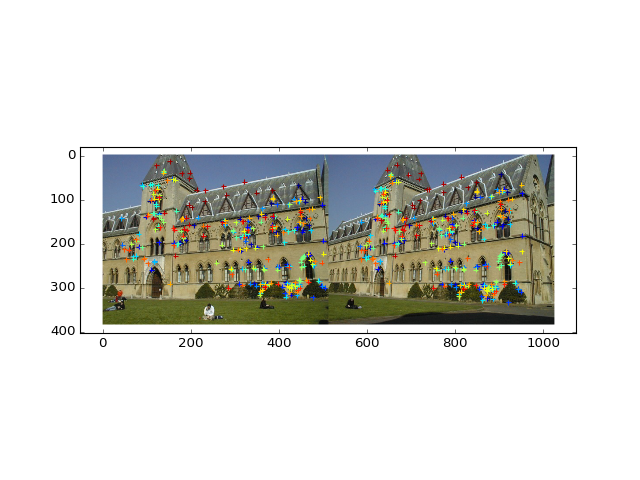

In [35]:
## Load images, K matrices and matches
data_dir = os.path.join('..', 'data', name)

# images
I1 = scipy.misc.imread(os.path.join(data_dir, "{}1.jpg".format(name)))
I2 = scipy.misc.imread(os.path.join(data_dir, "{}2.jpg".format(name)))

# K matrices
K1 = np.array(scipy.io.loadmat(os.path.join(data_dir, "{}1_K.mat".format(name)))["K"], order='C')
K2 = np.array(scipy.io.loadmat(os.path.join(data_dir, "{}2_K.mat".format(name)))["K"], order='C')

# corresponding points
# this is a N x 4 where:
# matches[i,0:2] is a point in the first image
# matches[i,2:4] is the corresponding point in the second image
matches = np.loadtxt(os.path.join(data_dir, "{}_matches.txt".format(name)))

# visualize matches (disable or enable this whenever you want)
if plot:
    fig, ax = plt.subplots()
    ax.imshow(np.concatenate([I1, I2], axis=1))
    colors = cm.jet(np.linspace(0, 1, len(matches) - 1))
    ax.scatter(matches[:, 0], matches[:, 1], c=colors, marker='+')
    ax.scatter(matches[:, 2] + I1.shape[1], matches[:, 3], c=colors, marker='+')
    #ax.plot(np.array([matches[:, 0], matches[:, 2] + I1.shape[1]]), matches[:, [1, 3]].T, 'r', alpha=0.1)

In [24]:
# compute the fundamental matrix
(F, res_err) = r3d.fundamental_matrix(matches)
print('Residual in F = {}'.format(res_err))

Residual in F = 0.03510890539511282


In [25]:
# compute the essential matrix
E = np.dot(np.dot(K2.T, F), K1)

# compute the rotation and translation matrices
(R, t) = r3d.find_rotation_translation(E)

In [26]:
# Find R2 and t2 from R, t such that largest number of points lie in front
# of the image planes of the two cameras
P1 = np.dot(K1, np.concatenate([np.eye(3), np.zeros((3, 1))], axis=1))

# the number of points in front of the image planes for all combinations
num_points = np.zeros((len(t), len(R)))

# the reconstruction error for all combinations
errs = np.empty((len(t), len(R)))

for ti, t2 in enumerate(t):
    t2 = t[ti]
    for ri, R2 in enumerate(R):
        R2 = R[ri]
        P2 = np.dot(K2, np.concatenate([R2, t2[:, None]], axis=1))

        points_3d, errs[ti, ri] = r3d.find_3d_points(matches, P1, P2, R2, t2)

        Z1 = points_3d[:, 2]
        Z2 = (np.dot(R2[2], points_3d.T) + t2[2]).T
        num_points[ti, ri] = np.sum((Z1 > 0) & (Z2 > 0))

j = 0 # pick one out the best combinations
(ti, ri) = np.nonzero(num_points == np.max(num_points))
print('Reconstruction error = {}'.format(errs[ti[j], ri[j]]))

Reconstruction error = 0.07008139916642502


<IPython.core.display.Javascript object>


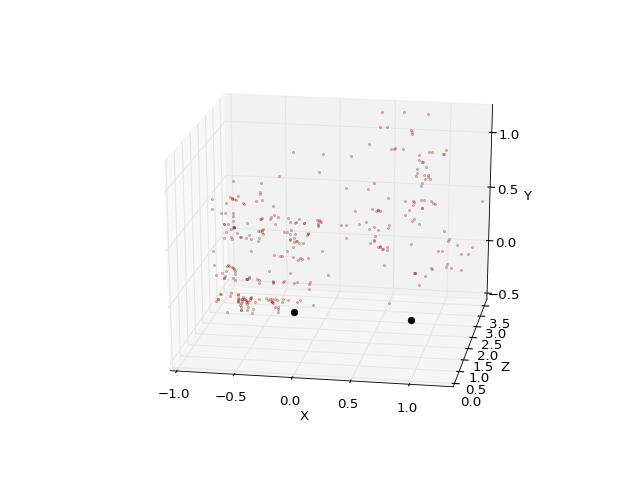

In [27]:
t2 = t[ti[j]]
R2 = R[ri[j]]
P2 = np.dot(K2, np.concatenate([R2, t2[:, None]], axis=1))

# compute the 3D points with the final P2
points, err = r3d.find_3d_points(matches, P1, P2, R2, t2)

r3d.plot_3d(points, R2, t2)

In [19]:
ax.set_zlim(-2, 2)

(-2, 2)